In [1]:
# Import necessary libraries
import tensorflow as tf
from tensorflow import keras
from keras.applications import ResNet50 , VGG16
from keras.layers import GlobalAveragePooling2D, Dense , Dropout , UpSampling2D , Flatten , BatchNormalization
from keras.models import Model , Sequential
from keras.datasets import cifar10
from keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

%matplotlib inline

In [2]:
# Load CIFAR-10 dataset and split into training and testing sets
(X_train , y_train) , (X_test , y_test) = cifar10.load_data()

# Normalize pixel values to the range [0, 1]
X_train , X_test = X_train / 255.0 , X_test / 255.0

# Print shapes of training and testing data arrays along with their labels
print("Training data shape:", X_train.shape)
print("Training labels shape:", y_train.shape)
print("Test data shape:", X_test.shape)
print("Test labels shape:", y_test.shape)

170498071/170498071 [==============================] - 13s 0us/step
Training data shape: (50000, 32, 32, 3)
Training labels shape: (50000, 1)
Test data shape: (10000, 32, 32, 3)
Test labels shape: (10000, 1)


In [3]:
# Define class labels for CIFAR-10 dataset
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']



# One-hot encode target labels
y_train_encoded = to_categorical(y_train, num_classes=10)
y_test_encoded = to_categorical(y_test, num_classes=10)





In [4]:
from tensorflow.keras.callbacks import  ModelCheckpoint



# Create callbacks including the learning rate scheduler
callbacks = [
    ModelCheckpoint("VGG_model.keras", save_best_only=True),  # Save the best model during training
]


In [5]:

# Create an ImageDataGenerator instance for data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,      # Randomly rotate images by up to 15 degrees
    width_shift_range=0.1,  # Randomly shift images horizontally by up to 10% of the width
    height_shift_range=0.1, # Randomly shift images vertically by up to 10% of the height
    horizontal_flip=True,   # Randomly flip images horizontally
    zoom_range=0.1,         # Randomly zoom into images by up to 10%
    fill_mode='nearest'     # Fill in missing pixels using the nearest available pixel
)




In [6]:

convolutional_base = VGG16(weights='imagenet', include_top=False, input_shape=(256,256,3))
convolutional_base.summary()

58889256/58889256 [==============================] - 4s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                              

In [7]:

# Create a Sequential model
model = Sequential()

# Upsample the input to match ResNet50 input size
model.add(UpSampling2D(size=(2, 2)))  # upsamples to (64, 64, 3)
model.add(UpSampling2D(size=(2, 2)))  # upsamples to (128, 128, 3)
model.add(UpSampling2D(size=(2, 2)))
# Add the ResNet50 base model
model.add(convolutional_base)

# Flatten the output for the fully connected layers
model.add(Flatten())
model.add(BatchNormalization())

# Add some fully connected layers for classification
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # Adding dropout regularization
model.add(BatchNormalization())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))  # Adding dropout regularization
model.add(BatchNormalization())

# Output layer for classification
model.add(Dense(10, activation='softmax'))


In [8]:



# Clear the TensorFlow session
tf.keras.backend.clear_session()

# Compile the model
optimizer = tf.keras.optimizers.RMSprop(learning_rate=2e-5)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
ResNet50_history = model.fit(datagen.flow(X_train,y_train_encoded,batch_size=32),
                             epochs=10,
                             validation_data=(X_test, y_test_encoded),
                             callbacks=callbacks,
                             verbose=1)



Epoch 1/10
1563/1563 [==============================] - 912s 564ms/step - loss: 2.2504 - accuracy: 0.2553 - val_loss: 3.3636 - val_accuracy: 0.2822
Epoch 2/10
1563/1563 [==============================] - 872s 558ms/step - loss: 1.7081 - accuracy: 0.4180 - val_loss: 1.1357 - val_accuracy: 0.6197
Epoch 3/10
1563/1563 [==============================] - 873s 559ms/step - loss: 1.4568 - accuracy: 0.5108 - val_loss: 1.0841 - val_accuracy: 0.6294
Epoch 4/10
1563/1563 [==============================] - 873s 558ms/step - loss: 1.2667 - accuracy: 0.5825 - val_loss: 1.1504 - val_accuracy: 0.6415
Epoch 5/10
1563/1563 [==============================] - 874s 559ms/step - loss: 1.1239 - accuracy: 0.6358 - val_loss: 0.7457 - val_accuracy: 0.7685
Epoch 6/10
1563/1563 [==============================] - 874s 559ms/step - loss: 1.0156 - accuracy: 0.6775 - val_loss: 0.6461 - val_accuracy: 0.7935
Epoch 7/10
1563/1563 [==============================] - 874s 559ms/step - loss: 0.9274 - accuracy: 0.7119 - val_

In [12]:

# Evaluate the model
VGG16_test_loss, VGG16_test_accuracy = model.evaluate(X_test, y_test_encoded)
print("VGG-16 Test Accuracy:", VGG16_test_accuracy)

313/313 [==============================] - 48s 153ms/step - loss: 0.5623 - accuracy: 0.8274
VGG-16 Test Accuracy: 0.8274000287055969


In [13]:
def plot_history(history, model_name):
    plt.figure(figsize=(12, 6))

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'{model_name} Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'{model_name} Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()


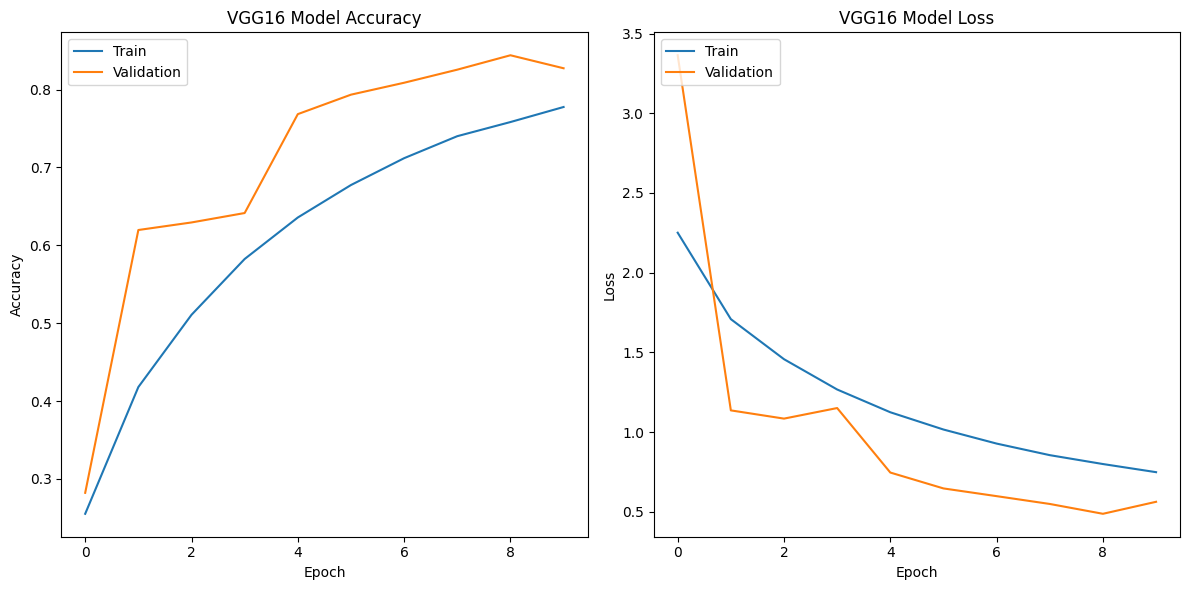

In [14]:
plot_history(ResNet50_history, 'VGG16')